## 0. Importation des modules et des fichiers


In [1]:
import datetime

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from scipy.optimize import minimize, fmin_slsqp, LinearConstraint
from sklearn.metrics import mean_squared_error

import matplotlib.gridspec as gd

# Méthode du synthetic control pour mesurer l'effet des "incentives" à la vaccination aux États-Unis

## 1. Définitions et traitement des données

In [2]:
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

states_names = {"AL":"Alabama", "AK":"Alaska", "AZ":"Arizona", "AR":"Arkansas",
                "CA":"California", "CO":"Colorado", "CT":"Connecticut",
                "DE":"Delaware", "FL":"Florida", "GA":"Georgia", "HI":"Hawaii",
                "ID":"Idaho", "IL":"Illinois", "IN":"Indiana", "IA":"Iowa",
                "KS":"Kansas", "KY":"Kentucky", "LA":"Louisiana", "ME":"Maine",
                "MD":"Maryland", "MA":"Massachusetts", "MI":"Michigan",
                "MN":"Minnesota", "MS":"Mississippi", "MO":"Missouri", "MT":"Montana",
                "NE":"Nebraska", "NV":"Nevada", "NH":"New Hampshire", "NJ":"New Jersey",
                "NM":"New Mexico", "NY":"New York", "NC":"North Carolina",
                "ND":"North Dakota", "OH":"Ohio", "OK":"Oklahoma", "OR":"Oregon",
                "PA":"Pennsylvania", "RI":"Rhode Island", "SC":"South Carolina",
                "SD":"South Dakota", "TN":"Tennessee", "TX":"Texas", "UT":"Utah",
                "VT":"Vermont", "VA":"Virginia", "WA":"Washington", "WV":"West Virginia",
                "WI":"Wisconsin", "WY":"Wyoming"}

In [4]:
#Données de vaccination par comté

path = 'vax_counties\COVID-19_Vaccinations_in_the_United_States_County.csv'
df_global = pd.read_csv(path, sep=',' )

c:\Users\antoi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# Traitement préalable de la base de données

df_global['State'] = df_global['Recip_State'].map(states_names)
df_global.drop(df_global.loc[(df_global['FIPS'] == "UNK")].index, inplace=True)
df_global = df_global.reset_index(drop = True)
df_global["FIPS"] = df_global["FIPS"].astype(int)

In [6]:
# Données du CCVI index

df_svi = pd.read_excel('COVID-19 Community Vulnerability Index (CCVI).xlsx', sheet_name = 'County CCVI')

# Tri : 

df_svi = df_svi.sort_values(by = ['State', 'County'])
df_svi = df_svi.reset_index(drop = True)

In [9]:
# Risk factors

path_cvd = 'como_data\como_cvd_mort_2016_2018.csv'
path_htn = 'como_data\como_htn_mort_2016_2018.csv'
path_medicare = 'como_data\como_medicareheartdizprev_2017.csv'
path_stroke_hosp = 'como_data\como_stroke_hosp_2015_2017.csv'
path_htn_hosp = 'como_data\como_htn_hosp_2015_2017.csv'
path_allheartdis = 'como_data\como_allheartdis_hosp_2015_2017.csv'

df_cvd = pd.read_csv(path_cvd, sep=',' )
df_htn = pd.read_csv(path_htn, sep='\t' )
df_medicare = pd.read_csv(path_medicare, sep=',' )
df_stroke_hosp = pd.read_csv(path_stroke_hosp, sep=',' )
df_htn_hosp = pd.read_csv(path_htn_hosp, sep='\t' )
df_allheartdis = pd.read_csv(path_allheartdis, sep=',')
df_countytype = pd.read_excel('vax_counties\County-Type-Share.xlsx', sheet_name = 'Sheet1')

c:\Users\antoi\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
df_cvd = df_cvd.drop(columns=['display_name','theme_range'])
df_htn = df_htn.drop(columns=['display_name','theme_range'])
df_medicare = df_medicare.drop(columns=['display_name','theme_range'])
df_stroke_hosp = df_stroke_hosp.drop(columns=['display_name','theme_range'])
df_htn_hosp = df_htn_hosp.drop(columns=['display_name','theme_range'])
df_allheartdis = df_allheartdis.drop(columns=['display_name','theme_range'])
df_countytype = df_countytype.drop(columns=['County','Type Number.1','Unnamed: 4','Key','New Names'])

In [11]:
fips_set = set(df_cvd["cnty_fips"]) & set(df_htn["cnty_fips"]) & set(df_medicare["cnty_fips"]) & set(df_global["FIPS"]) & set(df_svi["FIPS (5-digit)"]) & set(df_stroke_hosp["cnty_fips"]) & set(df_htn_hosp["cnty_fips"]) & set(df_allheartdis["cnty_fips"]) & set(df_countytype["FIPS"])
fips_list = list(fips_set)

In [12]:
fips_cvd_r = list(set(df_cvd["cnty_fips"])-fips_set)
fips_htn_r = list(set(df_htn["cnty_fips"])-fips_set)
fips_medicare_r = list(set(df_medicare["cnty_fips"])-fips_set)
fips_stroke_hosp_r = list(set(df_stroke_hosp["cnty_fips"])-fips_set)
fips_htn_hosp_r = list(set(df_htn_hosp["cnty_fips"])-fips_set)
fips_allheartdis_r = list(set(df_allheartdis["cnty_fips"])-fips_set)
fips_global_r = list(set(df_global["FIPS"])-fips_set)
fips_svi_r = list(set(df_svi["FIPS (5-digit)"])-fips_set)
fips_countytype = list(set(df_countytype["FIPS"])-fips_set)

for X in fips_cvd_r : 
    df_cvd.drop(df_cvd.loc[(df_cvd['cnty_fips'] == X)].index, inplace=True)
                
df_stroke_hosp = df_stroke_hosp.reset_index(drop = True)

for X in fips_stroke_hosp_r : 
    df_stroke_hosp.drop(df_stroke_hosp.loc[(df_stroke_hosp['cnty_fips'] == X)].index, inplace=True)
                
df_stroke_hosp = df_stroke_hosp.reset_index(drop = True)

for X in fips_htn_hosp_r : 
    df_htn_hosp.drop(df_htn_hosp.loc[(df_htn_hosp['cnty_fips'] == X)].index, inplace=True)
                
df_htn_hosp = df_htn_hosp.reset_index(drop = True)

for X in fips_allheartdis_r : 
    df_allheartdis.drop(df_allheartdis.loc[(df_allheartdis['cnty_fips'] == X)].index, inplace=True)
                
df_allheartdis = df_allheartdis.reset_index(drop = True)
                
for X in fips_htn_r : 
    df_htn.drop(df_htn.loc[(df_htn['cnty_fips'] == X)].index, inplace=True)
                
df_htn = df_htn.reset_index(drop = True)

for X in fips_medicare_r : 
    df_medicare.drop(df_medicare.loc[(df_medicare['cnty_fips']== X)].index, inplace=True)
                
df_medicare = df_medicare.reset_index(drop = True)

for X in fips_global_r : 
    df_global.drop(df_global.loc[(df_global['FIPS'] == X)].index, inplace=True)
                
df_global = df_global.reset_index(drop = True)

for X in fips_cvd_r :
    df_svi.drop(df_svi.loc[(df_svi['FIPS (5-digit)'] == X)].index, inplace=True)
                
df_svi = df_svi.reset_index(drop = True)

for X in fips_countytype :
    df_countytype.drop(df_countytype.loc[(df_countytype['FIPS'] == X)].index, inplace=True)
                
df_countytype = df_countytype.reset_index(drop = True)

In [13]:
df_cvd.rename(columns={'cnty_fips': 'FIPS'}, inplace=True)
df_htn.rename(columns={'cnty_fips': 'FIPS'}, inplace=True)
df_medicare.rename(columns={'cnty_fips': 'FIPS'}, inplace=True)
df_svi.rename(columns={'FIPS (5-digit)': 'FIPS'}, inplace=True)
df_stroke_hosp.rename(columns={'cnty_fips': 'FIPS'}, inplace=True)
df_htn_hosp.rename(columns={'cnty_fips': 'FIPS'}, inplace=True)
df_allheartdis.rename(columns={'cnty_fips': 'FIPS'}, inplace=True)

df_cvd = df_cvd.sort_values(by = ['FIPS'])
df_htn = df_htn.sort_values(by = ['FIPS'])
df_medicare = df_medicare.sort_values(by = ['FIPS'])
df_svi = df_svi.sort_values(by = ['FIPS'])
df_stroke_hosp = df_stroke_hosp.sort_values(by = ['FIPS'])
df_htn_hosp = df_htn_hosp.sort_values(by = ['FIPS'])
df_allheartdis = df_allheartdis.sort_values(by = ['FIPS'])
df_countytype = df_countytype.sort_values(by = ['FIPS'])

df_cvd = df_cvd.reset_index(drop = True)
df_htn = df_htn.reset_index(drop = True)
df_medicare = df_medicare.reset_index(drop = True)
df_svi = df_svi.reset_index(drop = True)
df_stroke_hosp = df_stroke_hosp.reset_index(drop = True)
df_htn_hosp = df_htn_hosp.reset_index(drop = True)
df_allheartdis = df_allheartdis.reset_index(drop = True)
df_countytype = df_countytype.reset_index(drop = True)

In [14]:
df_svi["Cardiovascular Disease Death Rate"] = list(df_cvd["Value"])
df_svi["Hypertension Death Rate"] = list(df_htn["Value"])
df_svi["Prevalence of heart disease among Medicare beneficiaries"] = list(df_medicare["Value"])
df_svi["Stroke Hospitalization Rate"] = list(df_stroke_hosp["Value"])
df_svi["Hypertension Hospitalization Rate"] = list(df_htn_hosp["Value"])
df_svi["Heart Disease Hospitalization Rate"] = list(df_allheartdis["Value"])

In [15]:
# Importation des données de vaccination sous forme d'un dictionnaire

fips_list = list(set(df_global["FIPS"].to_list())) # Extraction des FIPS pour créer une clé (State, County)

df_counties = {}

for X in fips_list:
    df_current_fips = df_global.loc[df_global['FIPS'] == X].copy()
    df_current_fips = df_current_fips.loc[::-1].reset_index(drop=True)
    current_state,current_county = df_current_fips["Recip_State"][0],df_current_fips["Recip_County"][0]
    df_counties[(current_county,current_state,X)] = df_current_fips

In [16]:
# la liste ci-dessous contient les couples comtés-états-fips et le dictionnaire associé à pour valeurs les dataframes avec comme clés ces couples

counties = list(df_counties.keys())

len(counties)

3140

In [17]:
census_list = ['Census2019_5PlusPop', 'Census2019_5to17Pop', 'Census2019_12PlusPop',
       'Census2019_18PlusPop', 'Census2019_65PlusPop']

tf = len(df_counties[counties[0]])

# On enlève les comtés inconnus 

for X in df_counties:
    if X[0] == 'Unknown County':
        counties.remove(X)        

# On ajoute les données du census : 

for census in census_list:
    for X in counties:
        df_counties[X][census] = df_counties[X][census][tf-1]

In [18]:
# On sélectionnera ici la catégorie d'âge souhaitée en choissant les bornes du jeu de données:
# Acceptable lower bounds : 'inf', '12', '18', '65',  
# Acceptable upper bounds : '18', '65', 'inf'
# Acceptable vaccinal schemes : 'Administered_Dose1_Recip', 'Series_Complete'

df_counties_cond = {}

def cat_age_vax(lb,ub,vax_scheme):
    for X in counties:
        df_current_county = df_counties[X].copy()
        if ub != "inf":
            df_current_county[vax_scheme+'_'+lb+'to'+ub] = df_current_county[vax_scheme+'_'+lb+'Plus'] - df_current_county[vax_scheme+'_'+ub+'Plus']
            df_current_county['Census2019_'+lb+'to'+ub+'Pop'] = df_current_county['Census2019_'+lb+'PlusPop'] - df_current_county['Census2019_'+ub+'PlusPop']
            df_current_county[vax_scheme+'_'+lb+'to'+ub+'Pop_Pct'] = df_current_county[vax_scheme+'_'+lb+'to'+ub]*100/df_current_county['Census2019_'+lb+'to'+ub+'Pop']
            df_counties_cond[X] = df_current_county[["Date",vax_scheme+'_'+lb+'to'+ub+'Pop_Pct',vax_scheme+'_'+lb+'to'+ub,'Census2019_'+lb+'to'+ub+'Pop']]
        else : 
            if lb == "inf":
                df_current_county.rename(columns={'Administered_Dose1_Recip': 'Dose', vax_scheme[:-5]+"Pop_Pct":'Pct', "Census2019": "Census"}, inplace=True)
                df_counties_cond[X] = df_current_county[["Date",'Pct','Dose','Census']]
            else:
                df_counties_cond[X] = df_current_county[["Date",vax_scheme+'_'+lb+'PlusPop_Pct',vax_scheme+'_'+lb+'Plus','Census2019_'+lb+'PlusPop']]
        df_counties_cond[X].set_axis(['Date', 'Pct', 'Dose' ,'Census'], axis='columns', inplace=True)

In [19]:
cat_age_vax('inf','inf','Administered_Dose1_Recip')

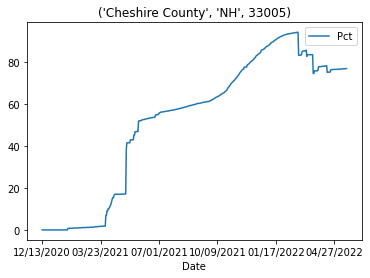

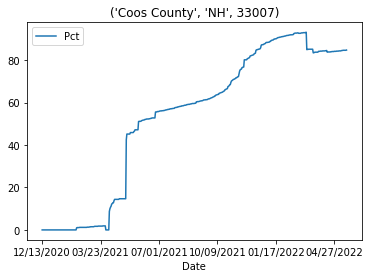

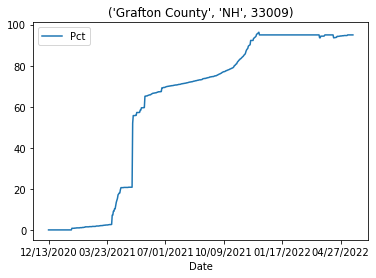

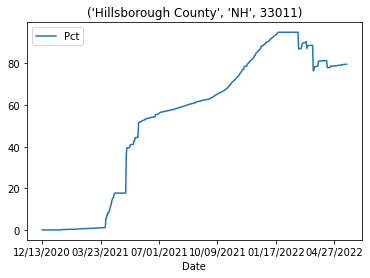

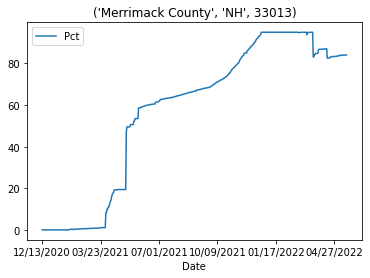

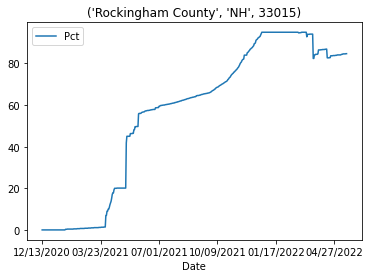

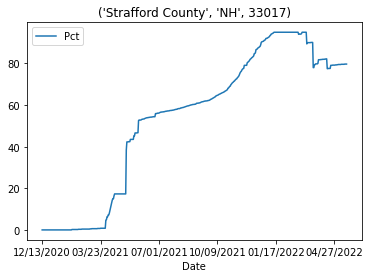

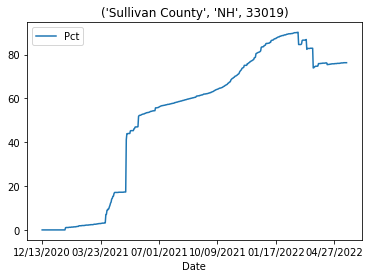

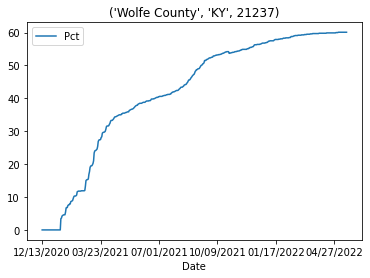

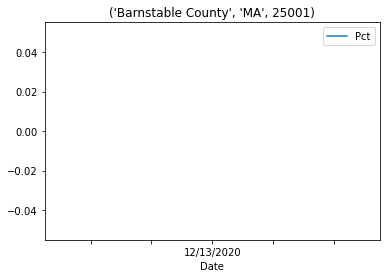

In [20]:
# Exemples de données de vaccination pour certains comtés :

df_counties_cond[counties[0]]
for k in range(40,50):
    df_counties_cond[counties[k]].plot(x='Date', y='Pct',title=str(counties[k]))

In [21]:
# On vérifie que nos dataframe ont bien la même taille : 

(len(df_counties_cond),len(df_svi),len(df_countytype))

(3140, 3140, 3140)

In [22]:
df_counties_cond_keys = list(df_counties_cond.keys()).copy()
counties_to_remove = []

#On a des comtés avec que des nan ou des 0: on les supprime

for X in df_counties_cond_keys:
    c = df_counties_cond[X]["Pct"].to_numpy()
    if np.count_nonzero(np.isnan(c)) > 0.9*len(df_counties_cond[X]) :
        df_counties_cond.pop(X)
        if X in counties:
            counties.remove(X)
        counties_to_remove.append(X)
        print(X)
    if c.sum() < 1:
        df_counties_cond.pop(X)
        if X in counties:
            counties.remove(X)
        counties_to_remove.append(X)
        print(X)   

# On enlève les comtés dont on n'a pas les données du census :

for X in df_counties_cond_keys:
    if X in df_counties_cond:
        if sum(df_counties_cond[X]['Census'].isnull()) == len(df_counties_cond[X]):
            df_counties_cond.pop(X)
            if X in counties:
                counties.remove(X)
            counties_to_remove.append(X)
            print(X)

    else:
        if X in counties:
            counties.remove(X)
        counties_to_remove.append(X)
        print(X)


('Barnstable County', 'MA', 25001)
('Dukes County', 'MA', 25007)
('Nantucket County', 'MA', 25019)
('Hawaii County', 'HI', 15001)
('Honolulu County', 'HI', 15003)
('Kalawao County', 'HI', 15005)
('Kauai County', 'HI', 15007)
('Maui County', 'HI', 15009)
('Barnstable County', 'MA', 25001)
('Dukes County', 'MA', 25007)
('Nantucket County', 'MA', 25019)
('Hawaii County', 'HI', 15001)
('Honolulu County', 'HI', 15003)
('Kalawao County', 'HI', 15005)
('Kauai County', 'HI', 15007)
('Maui County', 'HI', 15009)


In [23]:
for X in counties_to_remove:
    df_svi.drop(df_svi.loc[(df_svi['FIPS'] == X[2])].index, inplace=True)
    df_countytype.drop(df_countytype.loc[(df_countytype['FIPS'] == X[2])].index, inplace=True)

df_svi = df_svi.reset_index(drop = True)
df_countytype = df_countytype.reset_index(drop = True)

In [24]:
# On remarque qu'il y a des soucis dans le report des doses administrées : il arrive que le pourcentage de doses
# administrées diminue, alors qu'il ne devrait qu'augmenter ou rester constant (cf. explications dans le rapport)
# On décide donc de remédier à ces erreurs en fixant un seuil pour éviter que les données ne diminuent
# Dans un second temps, on effectue une interpolation sur la période où l'on constate des erreurs de report


tf = len(df_counties_cond[counties[0]])

print(len(counties))

k=0
for X in counties:
    if X in df_counties_cond :
        if X[1] == 'ID':
            v = df_counties_cond[X]['Pct'].rolling(7).mean()
            v = v.cummax()
            v[0:6] = 0
            df_counties_cond[X]['Pct'] = v
        else:
            for t in range(1,tf):                
                if df_counties_cond[X]['Pct'].loc[t] < df_counties_cond[X][('Pct')].loc[t-1] or np.isnan(df_counties_cond[X]['Pct'].loc[t]):
                    #on a un souci à partir du temps t
                    j = t
                    flag = True
                    while j < tf and flag:
                        if df_counties_cond[X]['Pct'].loc[j] >= df_counties_cond[X]['Pct'].loc[t-1]:
                            #on a trouvé le plus petit indice pour lequel les données redeviennent cohérentes
                            a_t = df_counties_cond[X]['Pct'].loc[t-1]
                            a_j = df_counties_cond[X]['Pct'].loc[j]

                            #on interpole linéairement
                            for i in range(t,j):
                                df_counties_cond[X]['Pct'].loc[i] = ((a_t-a_j)/(t-1-j))*(i-j) + a_j
                            flag = False
                        j +=1 

                    if flag:
                        #on a pas trouvé de plus petit indice: on crée un plateau à partir du temps t
                        for i in range(t,tf):
                            df_counties_cond[X]['Pct'].loc[i] = df_counties_cond[X][('Pct')].loc[t-1]
            v = df_counties_cond[X]['Pct'].rolling(7).mean()
            v[0:6] = df_counties_cond[X]['Pct'][0:6]
            df_counties_cond[X]['Pct'] = v

3132
('Baker County', 'OR', 41001)   1
('Benton County', 'OR', 41003)   2
('Clackamas County', 'OR', 41005)   3
('Clatsop County', 'OR', 41007)   4
('Columbia County', 'OR', 41009)   5
('Coos County', 'OR', 41011)   6


c:\Users\antoi\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


('Crook County', 'OR', 41013)   7
('Curry County', 'OR', 41015)   8
('Deschutes County', 'OR', 41017)   9
('Douglas County', 'OR', 41019)   10
('Gilliam County', 'OR', 41021)   11
('Grant County', 'OR', 41023)   12
('Harney County', 'OR', 41025)   13
('Hood River County', 'OR', 41027)   14
('Jackson County', 'OR', 41029)   15
('Jefferson County', 'OR', 41031)   16
('Josephine County', 'OR', 41033)   17
('Klamath County', 'OR', 41035)   18
('Lake County', 'OR', 41037)   19
('Lane County', 'OR', 41039)   20
('Lincoln County', 'OR', 41041)   21
('Linn County', 'OR', 41043)   22
('Malheur County', 'OR', 41045)   23
('Marion County', 'OR', 41047)   24
('Morrow County', 'OR', 41049)   25
('Multnomah County', 'OR', 41051)   26
('Polk County', 'OR', 41053)   27
('Sherman County', 'OR', 41055)   28
('Tillamook County', 'OR', 41057)   29
('Carroll County', 'GA', 13045)   30
('Umatilla County', 'OR', 41059)   31
('Union County', 'OR', 41061)   32
('Wallowa County', 'OR', 41063)   33
('Wasco Count

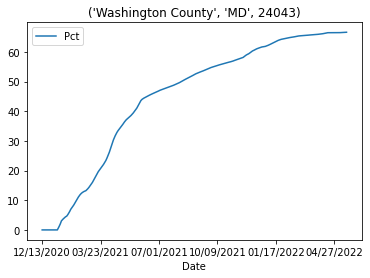

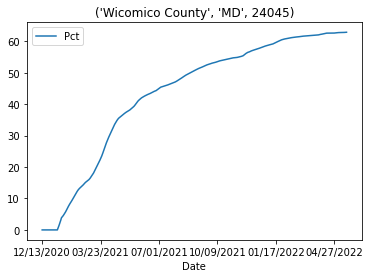

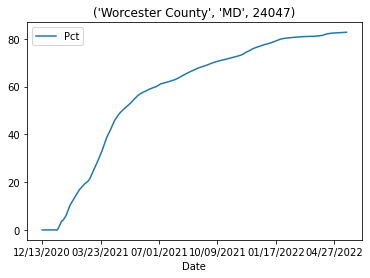

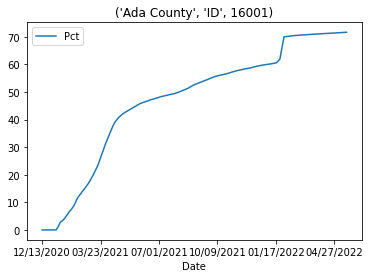

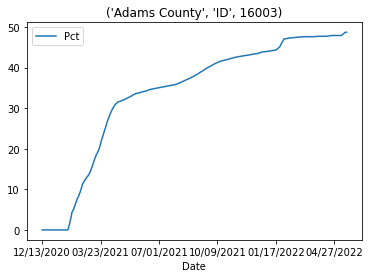

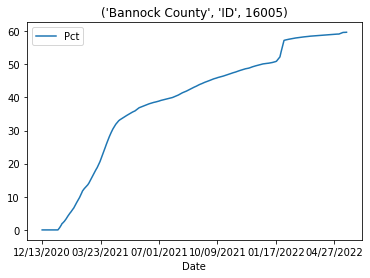

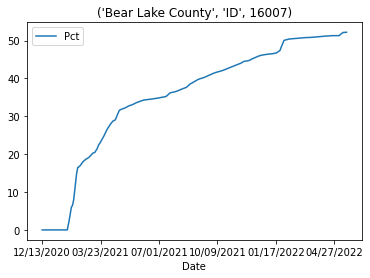

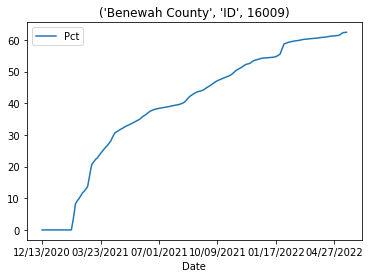

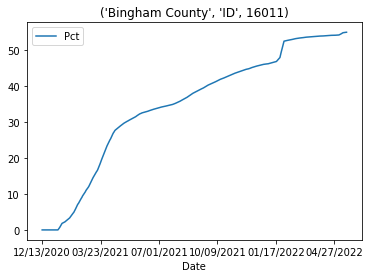

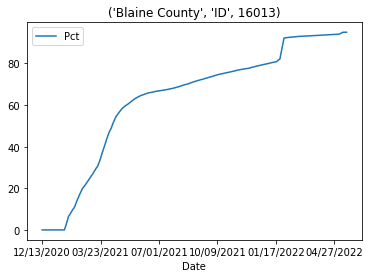

In [25]:
# Quelques exemples de courbes lissées :

for k in range(2990,3000):
    df_counties_cond[counties[k]].plot(x='Date', y='Pct',title=str(counties[k]))

In [26]:
# On vérifie que nos dataframe font la même taille : 

len(counties) == len(df_svi)

True

In [27]:
(len(df_counties_cond),len(df_svi),len(df_countytype))

(3132, 3132, 3132)

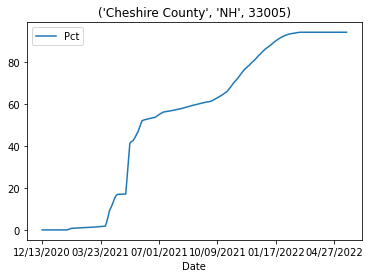

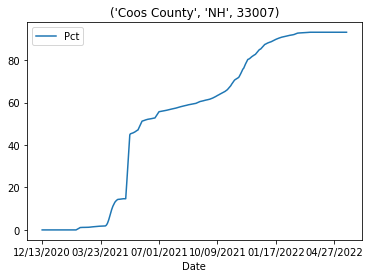

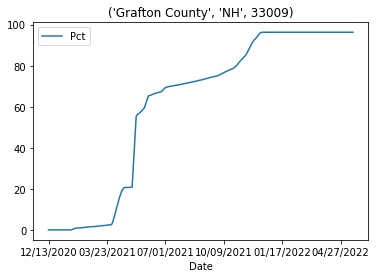

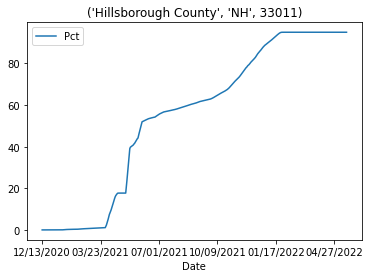

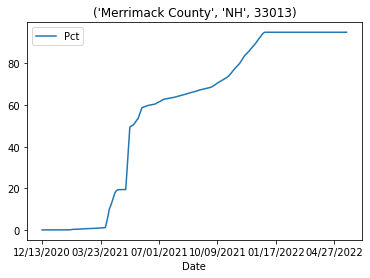

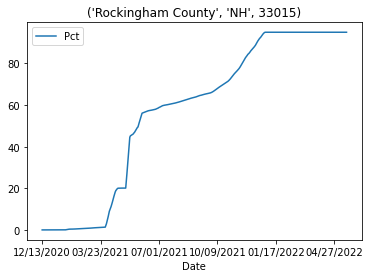

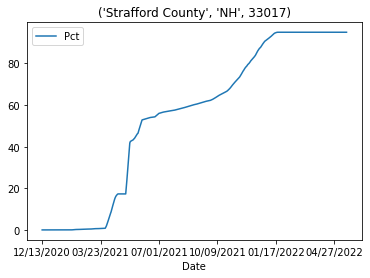

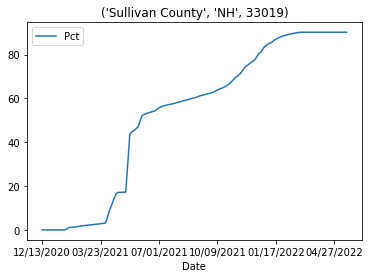

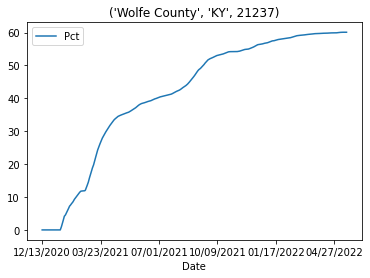

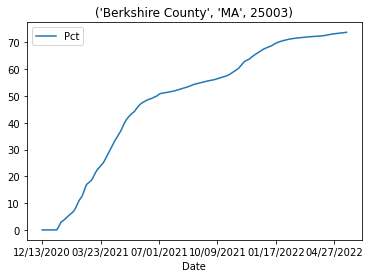

In [28]:
for k in range(40,50):
    df_counties_cond[counties[k]].plot(x='Date', y='Pct',title=str(counties[k]))

### Paramètres

In [29]:
# Pour plus de simplicité, on renomme le dataframe : 

df = df_counties_cond.copy()

In [30]:
# En fonction du type de dose et de la catégorie d'âge choisie, on a notre "response variable" 
# que l'on cherche à modéliser après l'intervention.

df_vax = {}
for X in counties: 
    df_vax[X] = df[X]['Pct']

ls_vax = {}
for X in counties:
    ls_vax[X] = df_vax[X].to_numpy()

In [31]:
# On renomme les colonnes : 

df_svi.rename(columns={'THEME 2:\nHousehold Composition & Disability': 'THEME 2: Household Composition & Disability', 'THEME 4: \nHousing Type & Transportation': 'THEME 4: Housing Type & Transportation', 'THEME 3: \nMinority Status & Language': 'THEME 3: Minority Status & Language'}, inplace=True)

In [32]:
# On crée un dictionnaire avec les données pour créer chaque comté synthétique : 

df_svi_prm = df_svi.copy()
county_vector = {}
for X in counties :
    county_vector[X] = df_svi.loc[(df_svi['State Abbreviation']==X[1]) & (df_svi['FIPS'] == X[2]),['THEME 1: Socioeconomic Status',
       'THEME 2: Household Composition & Disability',
       'THEME 3: Minority Status & Language',
       'THEME 4: Housing Type & Transportation',
       'THEME 5: Epidemiological Factors',
       'THEME 6: Healthcare System Factors','Cardiovascular Disease Death Rate', 'Hypertension Death Rate',
       'Prevalence of heart disease among Medicare beneficiaries','Stroke Hospitalization Rate', 'Hypertension Hospitalization Rate',
       'Heart Disease Hospitalization Rate']].values[0]

In [33]:
county_vector

{('Baker County',
  'OR',
  41001): array([  0.63482967,   0.69213626,   0.32187202,   0.78892073,
          0.84463547,   0.2330468 , 195.8       ,  81.5       ,
         26.2       ,   7.        ,   0.5       ,  16.6       ]),
 ('Benton County',
  'OR',
  41003): array([3.00859599e-01, 3.05635150e-02, 6.65393187e-01, 5.08436804e-01,
        9.13085005e-01, 2.54695957e-01, 1.53900000e+02, 9.06000000e+01,
        2.43000000e+01, 9.20000000e+00, 3.90000000e+00, 2.76000000e+01]),
 ('Clackamas County',
  'OR',
  41005): array([1.06653932e-01, 1.20343840e-01, 6.45017510e-01, 4.02101242e-01,
        6.74944290e-02, 3.08818848e-01, 1.73500000e+02, 1.05700000e+02,
        2.79000000e+01, 9.10000000e+00, 5.20000000e+00, 3.44000000e+01]),
 ('Clatsop County',
  'OR',
  41007): array([3.32378223e-01, 6.29417383e-01, 5.68290353e-01, 7.41801974e-01,
        1.45813435e-01, 3.21872015e-01, 2.15300000e+02, 1.05800000e+02,
        3.03000000e+01, 6.30000000e+00, 2.70000000e+00, 2.18000000e+01]),
 ('Co

In [34]:
# Normalisation et moyenne à 0

df_svi_prm = df_svi.drop(columns = [ 'State', 'County', 'State Abbreviation','FIPS','CCVI SCORE\nHigher = More Vulnerable'])
df_prm_scaled = (df_svi_prm-df_svi_prm.mean())/df_svi_prm.std()

county_vector_scaled = {}
for X in counties : 
    county_vector_scaled[X] = df_prm_scaled.loc[(df_svi['State Abbreviation']==X[1]) & (df_svi['FIPS'] == X[2]),].values[0]


In [35]:
county_vector_scaled

{('Baker County',
  'OR',
  41001): array([ 0.46611724,  0.66344478, -0.61408919,  1.00033026,  1.19065676,
        -0.9261486 , -0.5835377 , -0.62633563, -1.73292432, -0.71183222,
        -1.93700959, -1.76388462]),
 ('Benton County',
  'OR',
  41003): array([-0.6926556 , -1.6301956 ,  0.57671966,  0.02852488,  1.42749856,
        -0.85121816, -1.18146278, -0.49294483, -2.07614549, -0.26025475,
        -0.90309894, -1.02692015]),
 ('Clackamas County',
  'OR',
  41005): array([-1.36648918, -1.31893161,  0.50608781, -0.33990077, -1.49832389,
        -0.66389205, -0.90176513, -0.27160406, -1.42583169, -0.280781  ,
        -0.50778016, -0.57134212]),
 ('Clatsop County',
  'OR',
  41007): array([-0.58329572,  0.44600149,  0.24011474,  0.83707578, -1.2273328 ,
        -0.6187134 , -0.30526708, -0.27013822, -0.99228916, -0.85551596,
        -1.26800858, -1.41550141]),
 ('Columbia County',
  'OR',
  41009): array([-0.13039118, -0.10809258, -0.38784655,  0.01859724, -1.25266937,
         0.122

In [36]:
# Matrice des corrélations

df_prm_corr = df_prm_scaled.corr()
df_prm_corr.head()

,THEME 1: Socioeconomic Status,THEME 2: Household Composition & Disability,THEME 3: Minority Status & Language,THEME 4: Housing Type & Transportation,THEME 5: Epidemiological Factors,THEME 6: Healthcare System Factors,Cardiovascular Disease Death Rate,Hypertension Death Rate,Prevalence of heart disease among Medicare beneficiaries,Stroke Hospitalization Rate,Hypertension Hospitalization Rate,Heart Disease Hospitalization Rate
THEME 1: Socioeconomic Status,1.000000,0.627293,0.229618,0.471945,0.278884,0.300196,0.546305,0.326333,0.463601,0.336890,0.406123,0.441681
THEME 2: Household Composition & Disability,0.627293,1.000000,-0.067170,0.344898,0.248920,0.156368,0.435792,0.238579,0.349144,0.147202,0.122765,0.227529
THEME 3: Minority Status & Language,0.229618,-0.067170,1.000000,0.200922,-0.093334,0.013820,0.001577,0.157799,-0.006336,0.061482,0.143738,-0.024110
THEME 4: Housing Type & Transportation,0.471945,0.344898,0.200922,1.000000,-0.033380,0.007278,0.216982,0.128232,0.029321,-0.049276,-0.061514,-0.002237
THEME 5: Epidemiological Factors,0.278884,0.248920,-0.093334,-0.033380,1.000000,0.153232,0.312579,0.156638,0.356375,0.263409,0.320704,0.331798


<AxesSubplot:>

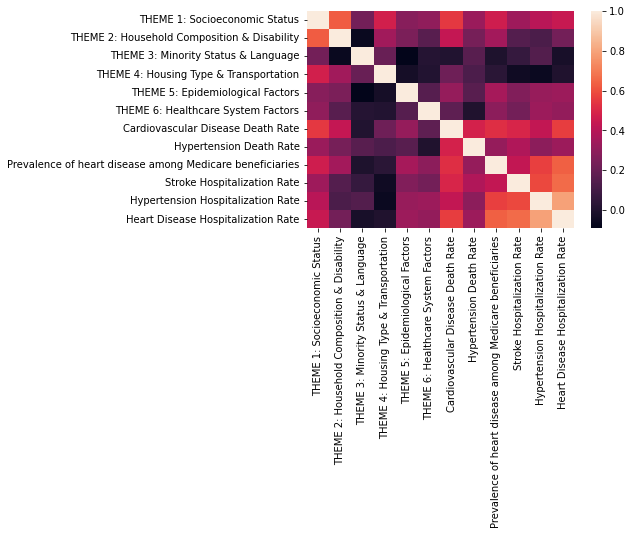

In [37]:
sns.heatmap(df_prm_corr)

In [41]:
# Définitions des états traités 

target_states_all = ['AL', 'AR', 'CA', 'CO', 'CT', 'DE', 'IL', 'ID', 'KY', 'ME', 'MD',
                'MI', 'MN', 'NJ', 'NY', 'OH', 'OR', 'WV']

control_states_all = []
for X in states:
    if X not in target_states_all:
        control_states_all.append(X)
        
#états frontaliers à l'Ohio

control_states_neighbours = ['IN','PA']

In [42]:
# Définition des comtés traités : 

target_counties_all = []

for X in counties : 
    if X[1] in target_states_all:
        target_counties_all.append(X)

print(len(target_counties_all))

1013


In [43]:
# On définit tous les comtés de contrôle

control_counties_all = []

for X in counties : 
    if X[1] in control_states_all:
        control_counties_all.append(X)

print(len(control_counties_all))

2118


In [44]:
# On se restreint qu'aux comtés de l'Ohio les plus peuplés :

target_counties_all_Ohio = []

for X in target_counties_all:
    if X[1] == 'OH':
        target_counties_all_Ohio.append(X)

In [45]:
dic_pop = {}

for X in target_counties_all_Ohio : 
    dic_pop[X] = df[X].loc[521,'Census']

sorteddict_pop = sorted(dic_pop.items(), key=lambda x: x[1], reverse = True)


In [48]:
# Choisir les bornes en fonction du nombre de comtés désirés : 

alpha = 0

beta = 0.1

sorteddict_pop_bis = sorteddict_pop[round(alpha*len(sorteddict_pop)):round(beta*len(sorteddict_pop))].copy()

In [49]:
target_counties_all_Ohio_bis = []

for X in sorteddict_pop_bis : 
    target_counties_all_Ohio_bis.append(X[0])


In [50]:
control_counties_Ohio_all = []

# On définit les comtés de contrôle dans la même catégorie que le comté target de l'Ohio traité : 
for X in target_counties_all_Ohio_bis:
    current_county_type = list(df_countytype.loc[(df_countytype['FIPS'] == X[2])]["Type Number"])[0]
    print(current_county_type)
    for Y in control_counties_all:
        ctrl_current_county_type = list(df_countytype.loc[(df_countytype['FIPS'] == Y[2])]["Type Number"])[0]
        if current_county_type == ctrl_current_county_type:
            control_counties_Ohio_all.append(Y)
            
control_counties_Ohio_all = list(set(control_counties_Ohio_all))
control_counties_Ohio_all

14
14
7
15
7
7
15
15
15


[('Lebanon County', 'PA', 42075),
 ('Racine County', 'WI', 55101),
 ('Duval County', 'FL', 12031),
 ('Bristol County', 'MA', 25005),
 ('Pima County', 'AZ', 4019),
 ('Greenville County', 'SC', 45045),
 ('Providence County', 'RI', 44007),
 ('Davidson County', 'TN', 47037),
 ('Forsyth County', 'NC', 37067),
 ('Lackawanna County', 'PA', 42069),
 ('Gwinnett County', 'GA', 13135),
 ('Lawrence County', 'PA', 42073),
 ('Washoe County', 'NV', 32031),
 ('Broward County', 'FL', 12011),
 ('Allen County', 'IN', 18003),
 ('East Baton Rouge Parish', 'LA', 22033),
 ('Blair County', 'PA', 42013),
 ('DeKalb County', 'GA', 13089),
 ('Hamilton County', 'TN', 47065),
 ('Lafayette Parish', 'LA', 22055),
 ('Guilford County', 'NC', 37081),
 ('Floyd County', 'IN', 18043),
 ('Snohomish County', 'WA', 53061),
 ('Jackson County', 'MO', 29095),
 ('Cobb County', 'GA', 13067),
 ('Clark County', 'IN', 18019),
 ('Hampden County', 'MA', 25013),
 ('Suffolk County', 'MA', 25025),
 ('Worcester County', 'MA', 25027),
 ('Hi

In [51]:
target_counties_all_Ohio_bis

[('Franklin County', 'OH', 39049),
 ('Cuyahoga County', 'OH', 39035),
 ('Hamilton County', 'OH', 39061),
 ('Summit County', 'OH', 39153),
 ('Montgomery County', 'OH', 39113),
 ('Lucas County', 'OH', 39095),
 ('Butler County', 'OH', 39017),
 ('Stark County', 'OH', 39151),
 ('Lorain County', 'OH', 39093)]

In [ ]:
# Importations des données relatives aux incentives

incentives = pd.read_excel('incentive_list.xlsx', 'Category and t0', index_col=None)

dates = {}
category = {}
for X in target_states_all:
    dates[X] = incentives.loc[incentives["State Code"] == X, "Incentive t0"]
    dates[X] = str(dates[X].item())[:10]
    category[X] = incentives.loc[incentives["State Code"] == X, "Category"]
    category[X] = int(category[X])

print(dates)
print(category)

### Synthetic control

In [57]:
# Définition des normes et des régularisations : 

    def norm(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.dot(pred_diff, pred_diff_v)
    return np.sqrt(res)

L1 = 0.2
L2 = 0.05

def norm_reg(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.sqrt(np.dot(pred_diff, pred_diff_v))
    res += L1/np.linalg.norm(w)
    res += L2/sum(np.abs(w))
    return res

def mspe(y1, y, w):
    interv = np.dot(np.transpose(y), w)
    interv_diff = y1 - interv
    res = np.dot(interv_diff, interv_diff)
    return res

In [58]:
# Définition des fonctions d'optimisation pour le contrôle synthétique

def constraint(w, v, x, x1):
    return np.sum(w) - 1

def con(v):
    return np.sum(v) - 1
cons = {'type':'eq', 'fun': con}

def mspe_opt_w(v_guess, w_guess, x, x1, y, y1):
    w_opt = fmin_slsqp(norm_reg, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v_guess, x, x1), disp=False)
    return mspe(y1, y, w_opt)

def opt_v(v_guess, w_guess, x, x1, y, y1):
    v_opt = minimize(mspe_opt_w, v_guess, constraints = cons, bounds=[(0.0, 1.0)]*len(v_guess), 
             args=(w_guess, x, x1, y, y1))
    return v_opt.x

def opt_w(w_guess, v, x, x1):
    w_opt = fmin_slsqp(norm_reg, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v, x, x1), disp=False)
    return w_opt

In [59]:
# Définition des dates de début des incentives par état

inc_t0 = {}

for X in target_states_all:
  # 19/02/2021 approx première date à laquelle les % de vax sont non nuls
  start = datetime.date(2021,2,19)
  t0_date_str = dates[X]
  t0_date = datetime.date(int(t0_date_str[:4]), int(t0_date_str[5:7]), int(t0_date_str[8:]))
  t0 = t0_date - start
  t0 = t0.days
  inc_t0[X] = t0

In [60]:
inc_t0

{'AL': 147,
 'AR': 96,
 'CA': 97,
 'CO': 95,
 'CT': 89,
 'DE': 95,
 'IL': 118,
 'ID': 102,
 'KY': 105,
 'ME': 81,
 'MD': 89,
 'MI': 132,
 'MN': 160,
 'NJ': 71,
 'NY': 77,
 'OH': 82,
 'OR': 91,
 'WV': 122}

In [67]:
target_counties_all = target_counties_all_Ohio_bis
target_states_all = ['OH']

len(control_counties_all)

[('Franklin County', 'OH', 39049),
 ('Cuyahoga County', 'OH', 39035),
 ('Hamilton County', 'OH', 39061),
 ('Summit County', 'OH', 39153),
 ('Montgomery County', 'OH', 39113),
 ('Lucas County', 'OH', 39095),
 ('Butler County', 'OH', 39017),
 ('Stark County', 'OH', 39151),
 ('Lorain County', 'OH', 39093)]

In [66]:
# Contrôle synthétique

y1_prediction = {}

def synthetic(ls_dose, county_vector_scaled, t_fit, plot=False):
    dfs=pd.DataFrame(columns=control_counties_all)
    V = []

    for X_target in target_counties_all:
        print(X_target)  
        if plot == True:
            print('The county of', X_target[1],X_target[0], 'is simulated with:')

        t0 = inc_t0[X_target[1]]

        y1 = ls_vax[X_target][t0-t_fit:t0]
        y = []
        for X in control_counties_all:   
            y.append(ls_vax[X][t0-t_fit:t0])
        y_post = []
        for X in control_counties_all:    
            y_post.append(ls_vax[X])

        x1 = county_vector_scaled[X_target]
        x = []
        for X in control_counties_all :    
            x.append(county_vector_scaled[X])

        k = len(x)
        j = len(x1)

        #v_guess = 1/np.array(df_svi_prm.std())
        v_guess = np.random.uniform(0,1,j)
        v_guess = v_guess/v_guess.sum()

        w_guess = np.random.uniform(0,1,k)
        w_guess = w_guess/w_guess.sum()
        
                     
        v_star = opt_v(v_guess, w_guess, x, x1, y, y1)
        w_star = opt_w(w_guess, v_star, x, x1)
        
        w_guess = w_star.copy()

        treshold = sorted(w_guess)[-5]

        for u in range(len(w_guess)):
            if w_guess[u] < 0.5*treshold:
                 w_guess[u] = 0

        w_guess = np.exp(2*len(w_guess)*w_guess)
        w_guess = w_guess/w_guess.sum()
        
        
        v_star = opt_v(v_star, w_guess, x, x1, y, y1)
        w_star = opt_w(w_guess, v_star, x, x1)
                
        print(np.round(w_star,3))

        # V.append(np.concatenate(([L], np.round(v_star, 3))))
        V.append(np.round(v_star, 3))

        y1_prediction[X_target] = np.dot(np.transpose(np.array(y_post)), np.array(w_star))

        df_new_row = pd.DataFrame(data=np.array([w_star]), columns=control_counties_all)

        dfs = pd.concat([dfs,df_new_row], ignore_index=True)

        inf = 0.01
        counties_star = {}

        for k in range(len(w_star)):
            if w_star[k]>inf:
                counties_star[control_counties_all[k]] = w_star[k]

        sortedDict = sorted(counties_star.items(), key=lambda x: x[1], reverse=True)
        
        for k in range(len(sortedDict)):
            print('   ',sortedDict[k][0][0], states_names[sortedDict[k][0][1]],np.round(sortedDict[k][1],3)*100,'%' )

        t = np.linspace(1,len(ls_vax[X_target]), len(ls_vax[X_target]))
        t_zoom = np.linspace(t0-40,t0+70, 110)

        plt.figure(figsize=(20, 16))

        plt.subplot(2, 2, 1) # row 1, col 2 index 1
        plt.plot(t, ls_vax[X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvline(x=t0-t_fit, ls='dotted', label= "début du fit")
        plt.legend()
        plt.title(X_target)

        plt.subplot(2, 2, 2) # row 1, col 2 index 1
        plt.plot(t_zoom, ls_vax[X_target][t0-40:t0+70], label='real')
        plt.plot(t_zoom, y1_prediction[X_target][t0-40:t0+70], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvline(x=t0-t_fit, ls='dotted', label= "début du fit")
        plt.legend()
        plt.title(X_target)  

        """
        plt.subplot(2, 2, 3) # row 1, col 2 index 1
        for X in control_counties_all:
            if X != X_target:
                plt.plot(t, ls_vax[X], 'b--', linewidth=0.5)
        plt.plot(t, ls_vax[X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvline(x=t0-t_fit, ls='dotted', label= "début du fit")
        plt.legend()
        plt.title(str(X_target)+' vs autres comtés de contrôle')

        plt.show()
        """

        print('')
    
    return V,dfs

('Hamilton County', 'OH', 39061)
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.789 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.211 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.   ]
    Dauphin County Pennsylvania 78.9 

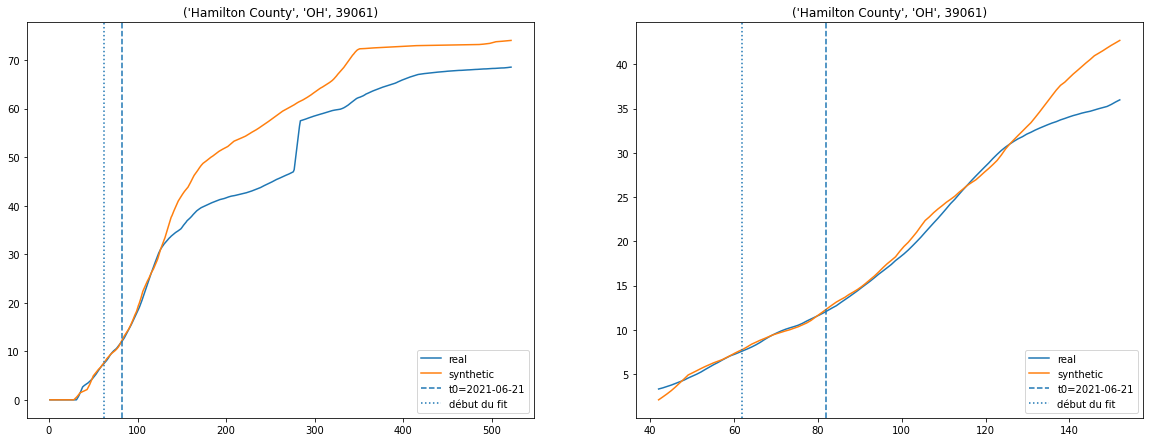

In [68]:
V,dfs = synthetic(ls_vax, county_vector_scaled, 20)


### Analyse des résultats

In [ ]:
# Delta entre pourcentage vacciné synthetic/réel intégré jusqu'à t0 Aire courbe pourcentage vacciné réel
# Proximité à 0 indique qualité du fit jusqu'à t0

def fit_q(ls_vax, y1_prediction, after_t0=False):
    fit_quality = []

    if after_t0 == False:
        for X in target_counties_all:
            t0 = inc_t0[X[1]]
            err = mean_squared_error(ls_vax[X][:t0],y1_prediction[X][:t0])
            fit_quality.append(np.round(np.sqrt(err),2))
    else:
        for X in target_counties_all:
            t0 = inc_t0[X[1]]
            err = mean_squared_error(ls_vax[X][t0+1:],y1_prediction[X][t0+1:])
            fit_quality.append(np.round(np.sqrt(err),2))

    df_fit = pd.DataFrame(fit_quality, index = target_counties_all, columns=['%'])

    return df_fit

In [ ]:
# Delta entre pourcentage de vaccination synthétique et réel n jours après t0

time_delta = [0, 30, 60, 90]
def delta_y(ls_vax, y1_prediction):
    delta = []

    for X in target_counties_all:
        t0 = inc_t0[X[1]]
        delta += [[np.round(y1_prediction[X][t0+d] -ls_vax[X][t0+d],2) for d in time_delta]]

    df_delta = pd.DataFrame(delta, index = target_counties_all, columns = time_delta)


    return df_delta

In [ ]:
# Analyse de l'importance respective des coefficients des paramètres V*

def important_v(V):
    poids_v = pd.DataFrame(V, index=target_counties_all, columns=df_svi_prm.columns)
    poids_v1 = poids_v.astype('float64')


    fig, axes = plt.subplots(4, 3, figsize=(18, 30))
    j = 0
    for c in poids_v1.columns:
        var = poids_v1.loc[:,c]
        ax = sns.barplot(ax=axes[int(np.trunc(j/3)),j%3], x=target_counties_all_names, y=var, color="limegreen")
        # ax.set(yscale="log")
        ax.set(ylim=(0, 1))
        j+=1
    
    v_sum = poids_v1.sum()

    print("Most important parameters \n", v_sum.sort_values(ascending=False).head(), '\n')
    print("Least important parameters \n",v_sum.sort_values(ascending=False).tail())

In [ ]:
important_v(V)